In [1]:
import matplotlib.pyplot as plt
from autograd import grad
import autograd.numpy as np
from math import *
import random
import pymc3 as pm
import theano
import theano.tensor as tt

%matplotlib inline

theano.config.compute_test_value = 'ignore'

In [2]:
N =2

beta_i = -2.7
b = 14.6
nu_0 = 100.
a_i = 1.

def vis_sps(theta_i,sig_1,sig_2,nu=100.) :
    lm = 3e8 / (nu * 1e6)
    T = a_i * (nu/nu_0)**beta_i
    A_p = tt.exp(-0.5*((theta_i/(sig_1*np.pi/180.))**2 + (theta_i/(sig_2*np.pi/180.))**2))
    f = tt.exp(-1j*2*pi*b*theta_i*lm)
    return  T*A_p*f

def vis_mps(theta,sig_1,sig_2,nu=100.) :
    real_res = 0
    imag_res = 0
    for  i in range(N):
        theta_i = theta[i]
        real_res += tt.real(vis_sps(theta_i,sig_1,sig_2,nu))
        imag_res += tt.imag(vis_sps(theta_i,sig_1,sig_2,nu))
    return [real_res,imag_res]


freq_min = 100.
freq_max = 110.
freq_range = np.linspace(freq_min,freq_max,num=60)

angle_min = -pi/2
angle_max = pi/2
sig_min = 5.
sig_max = 100.

N_datapts = 60 #number of data points
sigma = 0.1  # standard deviation of noise

true_params = [0.1 + 0.001*np.random.randn() for i in range(N)]   + [10.,10.]

In [3]:
nu = tt.dvector('nu')

theta_i = tt.dscalar('theta_i')
sig1 = tt.dscalar('sig1')
sig2 = tt.dscalar('sig2')

vis_sps_tt = theano.function([theta_i, sig1, sig2,nu], vis_sps(theta_i,sig1,sig2,nu))

theta = tt.dvector('theta')

vis_mps_tt = theano.function([theta, sig1, sig2,nu] , vis_mps(theta, sig1, sig2,nu))

In [4]:
def my_model(param,nu) :
    theta = param[0:N]
    sig_1 = param[-2]
    sig_2 = param[-1]
    return vis_mps_tt(theta,sig_1,sig_2,nu)


def my_loglike(param, nu, data, sigma) :
    model = my_model(param,freq_range)
    return -0.5/(sigma**2) * (np.sum(model[0] - data[0])**2 + np.sum(model[1] - data[1])**2)

In [5]:
data = my_model(true_params,freq_range) + 0.001*np.random.randn(N_datapts)

In [6]:
import warnings

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
              epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

In [7]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, nu, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.nu = nu
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.nu, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        param, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(param, self.nu, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        param, = inputs  # our parameters
        return [g[0]*self.logpgrad(param)]


class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, nu, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.nu = nu
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        param, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.nu, self.data, self.sigma)

        # calculate gradients
        grads = gradients(param, lnlike)

        outputs[0][0] = grads

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_2, sig_1, theta_2, theta_1]
Sampling 4 chains, 1,217 divergences: 100%|██████████| 22000/22000 [33:03<00:00, 11.09draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.004709861244813907, but should be close to 0.8. Try to increase the number of tuning steps.
There were 777 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44014963515304356, but should be close to 0.8. Try to increase the number of tuning steps.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.08838265690830857, but should be close to 0.8. Try to increase the number of tuning steps.
There were 213 divergences after t

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efeb9039810>,
      dtype=object)

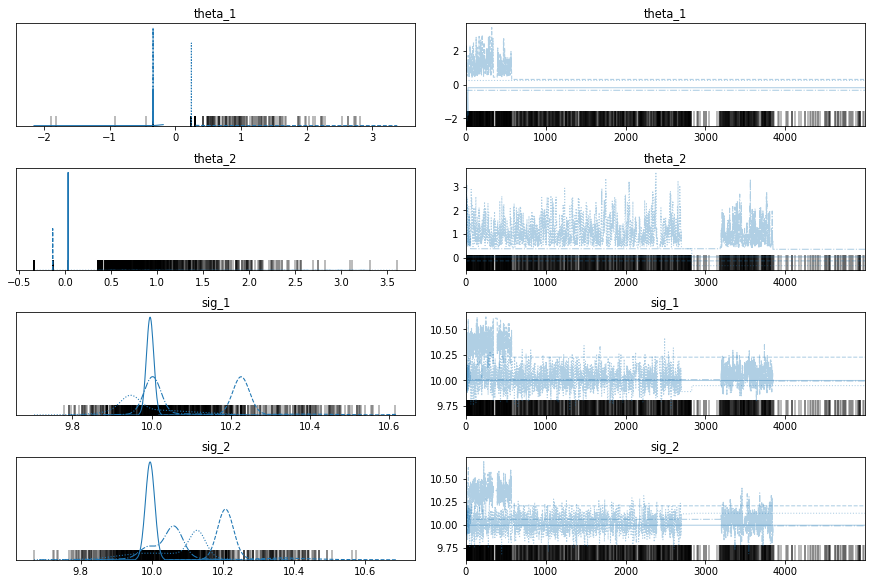

In [8]:
ndraws = 5000  # number of draws from the distribution
nburn = 1000   # number of "burn-in points" (which we'll discard)

sigma = 1.

# create our Op
logl = LogLikeWithGrad(my_loglike, data, nu, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    param = []
    # Gaussian priors on parameters
    for i in range(N) :
        theta_i = pm.Normal('theta_'+str(i+1),mu=true_params[i],sigma=1)
        param.append(theta_i)
        
    sig_1 = pm.Normal('sig_1',mu=true_params[-2],sigma=0.1)
    param.append(sig_1)
    sig_2 = pm.Normal('sig_2',mu=true_params[-1],sigma=0.1)
    param.append(sig_2)
    
    
    # convert a and b to a tensor vector
    param_tensor = tt.as_tensor_variable(param)

    #use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': param_tensor})

    trace = pm.sample(ndraws) #, tune=nburn, discard_tuned_samples=True

# plot the traces
pm.traceplot(trace)